In [1]:
#Run with kernel qBraid-SDK on QBraid

from qiskit_nature.drivers import UnitsType, Molecule
from qiskit.algorithms import NumPyMinimumEigensolver, VQE, HamiltonianPhaseEstimation, PhaseEstimation
import numpy as np
from qiskit.utils import QuantumInstance
from qiskit import Aer
from qiskit.circuit.library import TwoLocal
from qiskit_nature.algorithms import VQEUCCFactory, GroundStateEigensolver, NumPyMinimumEigensolverFactory, BOPESSampler
from qiskit_nature.drivers.second_quantization import ElectronicStructureDriverType, ElectronicStructureMoleculeDriver
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_nature.mappers.second_quantization import ParityMapper, JordanWignerMapper, BravyiKitaevMapper
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit.opflow import StateFn, PauliExpectation,  CircuitSampler, PauliTrotterEvolution
import time, datetime
from qiskit.algorithms.optimizers import QNSPSA

In [2]:
import pandas as pd
import os.path

#### Different backends

In [3]:
from pytket.extensions.braket import BraketBackend

In [4]:
from qiskit.test.mock import FakeVigo
from qiskit.providers.aer import AerSimulator
from qiskit.providers.aer import QasmSimulator
from qiskit.providers.aer.noise import NoiseModel

/tmp/ipykernel_30288/2246937046.py:1: DeprecationWarning: The module 'qiskit.test.mock' is deprecated since Qiskit Terra 0.21.0, and will be removed 3 months or more later. Instead, you should import the desired object directly 'qiskit.providers.fake_provider'.
  from qiskit.test.mock import FakeVigo


In [5]:
backend = AerSimulator() #NOISE
device_backend = FakeVigo() #NOISE
device = QasmSimulator.from_backend(device_backend) #NOISE

In [6]:
coupling_map = device.configuration().coupling_map #NOISE
noise_model = NoiseModel.from_backend(device) #NOISE
basis_gates = noise_model.basis_gates #NOISE

In [7]:
from pytket.extensions.qiskit import IBMQEmulatorBackend

In [8]:
from qiskit import IBMQ
IBMQ.save_account('MY TOKEN',overwrite=True) # Save TOKEN to disk
IBMQ.load_account() # Load account from disk
IBMQ.providers()    # List all available providers

provider = IBMQ.get_provider(hub='ibm-q') #NOISE
#backend = provider.get_backend("ibmq_manila") # Specifying Quantum device

In [41]:
#backend = IBMQEmulatorBackend("ibmq_manila")

In [9]:
# noise details
coupling_map = device.configuration().coupling_map #NOISE
noise_model = NoiseModel.from_backend(device) #NOISE
basis_gates = noise_model.basis_gates #NOISE

In [10]:
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter

/tmp/ipykernel_30288/992398542.py:1: DeprecationWarning: The qiskit.ignis package is deprecated and has been supersceded by the qiskit-experiments project. Refer to the migration guide: https://github.com/Qiskit/qiskit-ignis#migration-guide on how to migrate to the new project.
  from qiskit.ignis.mitigation.measurement import CompleteMeasFitter


#### VQE solver

In [11]:
#quantum_instance = QuantumInstance(backend = Aer.get_backend('aer_simulator_statevector'))# NOISELESS

#To introduce noise
quantum_instance = QuantumInstance(backend=backend, 
                                   shots=8192, 
                                   noise_model=noise_model, 
                                  
                                   measurement_error_mitigation_cls=CompleteMeasFitter,
                                   cals_matrix_refresh_period=30)

In [12]:
numpy_solver = NumPyMinimumEigensolver() #gives the exact solution


two-local circuits

In [13]:
tl_circuit = TwoLocal(rotation_blocks = ['h', 'rx'], entanglement_blocks = 'cz',
                      entanglement='full', reps=2, parameter_prefix = 'y')

Create the VQE using the Two-Local circuit ansatz with the default Sequential Least Squares Programming optimizer:

In [14]:
vqe_tl_solver = VQE(ansatz = tl_circuit,
                     quantum_instance = QuantumInstance(Aer.get_backend('aer_simulator_statevector')))

In [15]:
vqe_ucc_solver = VQEUCCFactory(quantum_instance, ansatz=tl_circuit)

/tmp/ipykernel_30288/3916184536.py:1: DeprecationWarning: VQEUCCFactory Constructor: quantum_instance is no longer a positional argument as of version 0.4 and will be removed no sooner than 3 months after the release. Instead use it as a keyword argument
  vqe_ucc_solver = VQEUCCFactory(quantum_instance, ansatz=tl_circuit)


Create a callback function for the Quantum Natural SPSA (QN-SPSA) optimizer

In [16]:
qnspsa_loss = []
def qnspsaclb(nfev, x, fx, stepsize, accepted):
    qnspsa_loss.append(fx)

### Different chemical functions

In [17]:
def show_particle_nr(problem, show=True):
  particle_number = problem.grouped_property_transformed.get_property("ParticleNumber")
  num_particles = (particle_number.num_alpha, particle_number.num_beta)
  num_spin_orbitals = particle_number.num_spin_orbitals
  if show:
    print("Number of alpha electrons: {}".format(particle_number.num_alpha))
    print("Number of beta electrons: {}".format(particle_number.num_beta))
    print("Number of spin orbitals: {}".format(num_spin_orbitals))
  return particle_number

In [18]:
def fermion_to_qubit(f_op, second_q_op, mapper, truncate=20, two_qubit_reduction=False, z2symmetry_reduction=None, show=True): 
  if show:
    print("Qubit Hamiltonian operator")
  dmap = {"Jordan-Wigner": JordanWignerMapper(), "Parity": ParityMapper(), "Bravyi-Kitaev": BravyiKitaevMapper()}
  qubit_op = None
  qubit_converter = None
  for k, v in dmap.items():
    if k == mapper:
      if show:
        print("{} transformation ". format(mapper))
      qubit_converter = QubitConverter(v, two_qubit_reduction=two_qubit_reduction, z2symmetry_reduction=z2symmetry_reduction)
      if two_qubit_reduction:
        qubit_op = qubit_converter.convert(second_q_op[0], num_particles=f_op.num_particles)
      else:
        qubit_op = qubit_converter.convert(second_q_op[0])
      n_items = len(qubit_op)
      if show:
        print("Number of items in the Pauli list:", n_items)
        if n_items <= truncate:
          print(qubit_op)
        else:
          print(qubit_op[0:truncate])
  return qubit_op, qubit_converter

In [19]:
def run_vqe(name, f_op, qubit_converter, solver, show=True):
  calc = GroundStateEigensolver(qubit_converter, solver)
  start = time.time()
  ground_state = calc.solve(f_op)
  elapsed = str(datetime.timedelta(seconds = time.time()-start))
  if show:
    print("Running the VQE using the {}".format(name))
    print("Elapsed time: {} \n".format(elapsed))
    print(ground_state)
  return ground_state

run_qpe() function performs a phase estimation and returns an eigenvalue of a Hamiltonian as an estimation of the electronic ground state energy.

In [20]:
def run_qpe(particle_number, qubit_converter, qubit_op, n_ancillae=3, num_time_slices = 1, show=True):
  initial_state = HartreeFock(particle_number.num_spin_orbitals, 
                            (particle_number.num_alpha, 
                             particle_number.num_beta), qubit_converter)
  
  state_preparation = StateFn(initial_state)

  evolution = PauliTrotterEvolution('trotter', reps=num_time_slices)

  qpe = HamiltonianPhaseEstimation(n_ancillae, quantum_instance=quantum_instance)
  result = qpe.estimate(qubit_op, state_preparation, evolution=evolution)

  if show:
    print("\nQPE initial Hartree Fock state")
    display(initial_state.draw(output='mpl'))
    eigv = result.most_likely_eigenvalue
    print("QPE computed electronic ground state energy (Hartree): {}".format(eigv))
  
  return eigv

Plot the energy as a functoin of atomic separation:

In [21]:
def plot_energy_landscape(energy_surface_result):
  if len(energy_surface_result.points) > 1:
      plt.plot(energy_surface_result.points, energy_surface_result.energies, label="VQE Energy")
      plt.xlabel('Atomic distance Deviation(Angstrom)')
      plt.ylabel('Energy (hartree)')
      plt.legend()
      plt.show()
  else:
      print("Total Energy is: ", energy_surface_result.energies[0], "hartree")
      print("(No need to plot, only one configuration calculated.)")
  return

In [22]:
def plot_loss(loss, label, target):
  plt.figure(figsize=(12, 6))
  plt.plot(loss, 'tab:green', ls='--', label=label)
  plt.axhline(target, c='tab:red', ls='--', label='target')
  plt.ylabel('loss')
  plt.xlabel('iterations')
  plt.legend()

To solve for the energy values of the ground state, we specify the mapper, here Parity, since we can use it to reduce qubits, and the ansatz. Here the Numpy exact solver.

In [23]:
def solve_ground_state(
    molecule,
    mapper ="Parity",
    num_electrons=None,
    num_molecular_orbitals=None,
    transformers=None, #freezecoretransformer for LiH
    two_qubit_reduction=False,
    z2symmetry_reduction = "Auto",
    name_solver='NumPy exact solver',
    solver=NumPyMinimumEigensolver(),
    plot_bopes=False,
    perturbation_steps=np.linspace(-1, 1, 3),
    pyqmc=True,
    n_ancillae=3, 
    num_time_slices=1,
    loss=[],
    label=None,
    target=None,
    show=True
):

    # Defining the electronic structure molecule driver
    driver = ElectronicStructureMoleculeDriver(molecule, basis='sto3g', driver_type=ElectronicStructureDriverType.PYSCF)

    # Splitting into classical and quantum
    if num_electrons != None and num_molecular_orbitals != None:
      split = ActiveSpaceTransformer(num_electrons=num_electrons, num_molecular_orbitals=num_molecular_orbitals)
    else:
      split = None

    # Defining a fermionic Hamiltonian operator
    if split != None:
      fermionic_hamiltonian = ElectronicStructureProblem(driver, [split])
    elif transformers != None:
      fermionic_hamiltonian = ElectronicStructureProblem(driver, transformers=transformers)
    else:
      fermionic_hamiltonian = ElectronicStructureProblem(driver)

    # Use the second_q_ops() method [Qiskit_Nat_3] which returns a list of second quantized operators
    second_q_op = fermionic_hamiltonian.second_q_ops()
    
     # Get particle number
    particle_number = show_particle_nr(fermionic_hamiltonian, show=show)

    if show:
      # We set truncation to 1000 with the method set_truncation(1000)
      second_q_op[0].set_truncation(1000)
      # then we print the first 20 terms of the fermionic Hamiltonian operator of the molecule
      print("Fermionic Hamiltonian operator")
      print(second_q_op[0])
    
    # Use the function fermion_to_qubit() to convert a fermionic operator to a qubit operator
    if show:
      print(" ")
    qubit_op, qubit_converter = fermion_to_qubit(fermionic_hamiltonian, second_q_op, mapper=mapper, two_qubit_reduction=two_qubit_reduction, z2symmetry_reduction=z2symmetry_reduction, show=show)

    # Run the the PySCF RHF method
    if show:
      print(" ")
    conv, e = run_PySCF(molecule, pyqmc=pyqmc, show=show)

    # Run QPE
    eigv = run_qpe(particle_number, qubit_converter, qubit_op, n_ancillae=n_ancillae, num_time_slices=num_time_slices, show=show)

    # Run VQE, solve for the ground state
    if show:
      print(" ")
    ground_state = run_vqe(name_solver, fermionic_hamiltonian, qubit_converter, solver, show=show)

    # Plot loss function, evolution of loss as a function of iterations
    if loss != []:
      plot_loss(loss, label, target)

    if plot_bopes:
      # Compute the potential energy surface as follows:
      energy_surface = BOPESSampler(gss=GroundStateEigensolver(qubit_converter, solver), bootstrap=False)
      # Fix enables using BOPESS together with Unitary Coupled Cluster (UCC) factory ansatz
      # Set default to an empty dictionary instead of None:
      energy_surface._points_optparams = {}
      energy_surface_result = energy_surface.sample(fermionic_hamiltonian, perturbation_steps)

      # Plot the energy as a function of atomic separation
      plot_energy_landscape(energy_surface_result)

    return fermionic_hamiltonian, particle_number, qubit_op, qubit_converter, ground_state

In [24]:
def run_PySCF(molecule, pyqmc=True, show=True):
  # Reset the files
  for fname in ['mf.hdf5','optimized_wf.hdf5','vmc_data.hdf5','dmc.hdf5']:
    if os.path.isfile(fname):
        os.remove(fname)
  #Construct a PySCF molecular geometry from the molecule passed as an input parameter
  mol_PySCF = gto.M(atom = [" ".join(map(str, (name, *coord))) for (name, coord) in molecule.geometry])
  
  #Run the PySCF RHF method
  mf = scf.RHF(mol_PySCF)
  mf.chkfile = "mf.hdf5"
  
  conv, e, mo_e, mo, mo_occ = scf.hf.kernel(mf)
  if show:
    if conv:
      print("PySCF restricted HF (RHF) converged ground-state energy: {:.12f}".format(e))
    else:
      print("PySCF restricted HF (RHF) ground-state computation failed to converge")
   

  #Run the OPTIMIZE function in the PyQMC Python module:
  if pyqmc:
    pyq.OPTIMIZE("mf.hdf5",# Construct a Slater-Jastrow wave function from the pyscf output
      "optimized_wf.hdf5", # Store optimized parameters in this file.
      nconfig=100,         # Optimize using this many Monte Carlo samples/configurations
      max_iterations=4,    # 4 optimization steps
      verbose=False)
    #Read the content of the HDF5 file, which contains the optimized parameters, and if the PyQMC variational
    #Monte Carlo computation converged, then we print the energy of each iteration:
    with h5py.File("optimized_wf.hdf5") as f:
      iter = f['iteration']
      energy = f['energy']
      error = f['energy_error']
      l = energy.shape[0]
      e = energy[l-1]
      err = error[l-1]
      if show:
        if err < 0.1:
          print("Iteration, Energy, Error")
          for k in iter:
            print("{}:         {:.4f} {:.4f}".format(k, energy[k], error[k]))
          print("PyQMC Monte Carlo converged ground-state energy: {:.12f}, error: {:.4f}".format(e, err))
        else:
          print("PyQMC Monte Carlo failed to converge")
  #return conv,Boolean, set to True of the PySCF RHF method converged
  #e the energy of the ground state
  return conv, e

### The Hydrogen Molecule

In [25]:
h2_molecule = Molecule(geometry=[['H', [0., 0., 0.]],
                              ['H', [0., 0., 0.735]]],
                     charge=0, multiplicity=1)

Vary the molecule

In [26]:
varymol = Molecule.absolute_stretching

In [27]:
from functools import partial as apply_variation

first atom of the specified atom pair is moved closer to the second atom. 

In [28]:
varymolspec = apply_variation(varymol, atom_pair=(1, 0))

Change degreed of freedom to varymolspec

In [29]:
h2_molecule_stretchable = Molecule(geometry=
                                 [['H', [0., 0., 0.]],
                                  ['H', [0., 0., 0.735]]],
                                  charge=0, multiplicity=1,
                                  degrees_of_freedom=[varymolspec])

In [30]:
def solve_ground_state(
    molecule,
    mapper ="Parity",
    num_electrons=None,
    num_molecular_orbitals=None,
    transformers=None, #freezecoretransformer for LiH
    two_qubit_reduction=False,
    z2symmetry_reduction = "Auto",
    name_solver='NumPy exact solver',
    solver=NumPyMinimumEigensolver(),
    plot_bopes=False,
    perturbation_steps=np.linspace(-1, 1, 3),
    pyqmc=True,
    n_ancillae=3, 
    num_time_slices=1,
    loss=[],
    label=None,
    target=None,
    show=True
):

    # Defining the electronic structure molecule driver
    driver = ElectronicStructureMoleculeDriver(molecule, basis='sto3g', driver_type=ElectronicStructureDriverType.PYSCF)

    # Splitting into classical and quantum
    if num_electrons != None and num_molecular_orbitals != None:
      split = ActiveSpaceTransformer(num_electrons=num_electrons, num_molecular_orbitals=num_molecular_orbitals)
    else:
      split = None

    # Defining a fermionic Hamiltonian operator
    if split != None:
      fermionic_hamiltonian = ElectronicStructureProblem(driver, [split])
    elif transformers != None:
      fermionic_hamiltonian = ElectronicStructureProblem(driver, transformers=transformers)
    else:
      fermionic_hamiltonian = ElectronicStructureProblem(driver)

    # Use the second_q_ops() method [Qiskit_Nat_3] which returns a list of second quantized operators
    second_q_op = fermionic_hamiltonian.second_q_ops()
    
     # Get particle number
    particle_number = show_particle_nr(fermionic_hamiltonian, show=show)

    if show:
      # We set truncation to 1000 with the method set_truncation(1000)
      second_q_op[0].set_truncation(1000)
      # then we print the first 20 terms of the fermionic Hamiltonian operator of the molecule
      print("Fermionic Hamiltonian operator")
      print(second_q_op[0])
    
    # Use the function fermion_to_qubit() to convert a fermionic operator to a qubit operator
    if show:
      print(" ")
    qubit_op, qubit_converter = fermion_to_qubit(fermionic_hamiltonian, second_q_op, mapper=mapper, two_qubit_reduction=two_qubit_reduction, z2symmetry_reduction=z2symmetry_reduction, show=show)

    # Run the the PySCF RHF method
    if show:
      print(" ")
    conv, e = run_PySCF(molecule, pyqmc=pyqmc, show=show)

    # Run QPE
    eigv = run_qpe(particle_number, qubit_converter, qubit_op, n_ancillae=n_ancillae, num_time_slices=num_time_slices, show=show)

    # Run VQE, solve for the ground state
    if show:
      print(" ")
    ground_state = run_vqe(name_solver, fermionic_hamiltonian, qubit_converter, solver, show=show)

    # Plot loss function, evolution of loss as a function of iterations
    if loss != []:
      plot_loss(loss, label, target)

    if plot_bopes:
      # Compute the potential energy surface as follows:
      energy_surface = BOPESSampler(gss=GroundStateEigensolver(qubit_converter, solver), bootstrap=False)
      # Fix enables using BOPESS together with Unitary Coupled Cluster (UCC) factory ansatz
      # Set default to an empty dictionary instead of None:
      energy_surface._points_optparams = {}
      energy_surface_result = energy_surface.sample(fermionic_hamiltonian, perturbation_steps)

      # Plot the energy as a function of atomic separation
      plot_energy_landscape(energy_surface_result)

    return fermionic_hamiltonian, particle_number, qubit_op, qubit_converter, ground_state

#### Find the ground state energy values

Run VQE with NumPy exact minimum eigensolver

In [31]:
from pyscf import gto, scf

In [32]:
import pyqmc.api as pyq
import h5py
from qiskit_nature.circuit.library.initial_states import HartreeFock

/home/jovyan/.qbraid/environments/qbraid_sdk_9j9sjy/pyenv/lib/python3.9/site-packages/qiskit_nature/problems/second_quantization/electronic/electronic_structure_problem.py:93: ListAuxOpsDeprecationWarning: List-based `aux_operators` are deprecated as of version 0.3.0 and support for them will be removed no sooner than 3 months after the release. Instead, use dict-based `aux_operators`. You can switch to the dict-based interface immediately, by setting `qiskit_nature.settings.dict_aux_operators` to `True`.
  second_quantized_ops = self._grouped_property_transformed.second_q_ops()


Number of alpha electrons: 1
Number of beta electrons: 1
Number of spin orbitals: 4
Fermionic Hamiltonian operator
Fermionic Operator
register length=4, number terms=36
  -1.2563390730032498 * ( +_0 -_0 )
+ -0.47189600728114245 * ( +_1 -_1 )
+ -1.2563390730032498 * ( +_2 -_2 )
+ -0.47189600728114245 * ( +_3 -_3 )
+ -0.33785507740175813 * ( +_0 +_0 -_0 -_0 )
+ -0.09046559989211564 * ( +_0 +_1 -_1 -_0 )
+ -0.09046559989211556 * ( +_0 +_0 -_1 -_1 )
+ -0.33229086512764816 * ( +_0 +_1 -_0 -_1 )
+ -0.33785507740175813 * ( +_0 +_2 -_0 -_2 )
+ -0.09046559989211564 * ( +_0 +_3 -_1 -_2 )
+ -0.09046559989211556 * ( +_0 +_2 -_1 -_3 )
+ -0.33229086512764816 * ( +_0 +_3 -_0 -_3 )
+ -0.33229086512764827 * ( +_1 +_0 -_1 -_0 )
+ -0.09046559989211574 * ( +_1 +_1 -_0 -_0 )
+ -0.09046559989211565 * ( +_1 +_0 -_0 -_1 )
+ -0.34928686136600906 * ( +_1 +_1 -_1 -_1 )
+ -0.33229086512764827 * ( +_1 +_2 -_1 -_2 )
+ -0.09046559989211574 * ( +_1 +_3 -_0 -_2 )
+ -0.09046559989211565 * ( +_1 +_2 -_0 -_3 )
+ -0.34928

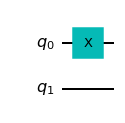

QPE computed electronic ground state energy (Hartree): -1.793437861067976
 
Running the VQE using the NumPy exact solver
Elapsed time: 0:00:01.493139 

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.857275030202
  - computed part:      -1.857275030202
~ Nuclear repulsion energy (Hartree): 0.719968994449
> Total ground state energy (Hartree): -1.137306035753
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  1.3889487]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  1.3889487]
    - computed part:      [0.0  0.0  1.3889487]
  > Dipole moment (a.u.): [0.0  0.0  0.0]  Total: 0.0
                 (debye): [0.0  0.0  0.0]  Total: 0.0
 


In [33]:
H2_fermionic_hamiltonian, H2_particle_number, H2_qubit_op, H2_qubit_converter, H2_ground_state = \
                  solve_ground_state(h2_molecule, mapper ="Parity",
                   two_qubit_reduction=True, z2symmetry_reduction=None, 
                   name_solver = 'NumPy exact solver', solver = numpy_solver)

Run the VQE with the UCC factory ANSATZ 

##### If the following cell generates an error,  continue to the next one

In [34]:
#H2_fermionic_hamiltonian, H2_particle_number, H2_qubit_op, H2_qubit_converter, H2_ground_state = \
 #                 solve_ground_state(h2_molecule, mapper ="Parity",
  #                 two_qubit_reduction=True, z2symmetry_reduction=None, 
   #                name_solver = 'Unitary Coupled Cluster (UCC) factory ansatz', solver = vqe_ucc_solver)

Run the VQE using a heuristic ansatz, the Two-Local circuit with the default SLSQP optimizer.

Number of alpha electrons: 1
Number of beta electrons: 1
Number of spin orbitals: 4
Fermionic Hamiltonian operator
Fermionic Operator
register length=4, number terms=36
  -1.2563390730032498 * ( +_0 -_0 )
+ -0.47189600728114245 * ( +_1 -_1 )
+ -1.2563390730032498 * ( +_2 -_2 )
+ -0.47189600728114245 * ( +_3 -_3 )
+ -0.33785507740175813 * ( +_0 +_0 -_0 -_0 )
+ -0.09046559989211564 * ( +_0 +_1 -_1 -_0 )
+ -0.09046559989211556 * ( +_0 +_0 -_1 -_1 )
+ -0.33229086512764816 * ( +_0 +_1 -_0 -_1 )
+ -0.33785507740175813 * ( +_0 +_2 -_0 -_2 )
+ -0.09046559989211564 * ( +_0 +_3 -_1 -_2 )
+ -0.09046559989211556 * ( +_0 +_2 -_1 -_3 )
+ -0.33229086512764816 * ( +_0 +_3 -_0 -_3 )
+ -0.33229086512764827 * ( +_1 +_0 -_1 -_0 )
+ -0.09046559989211574 * ( +_1 +_1 -_0 -_0 )
+ -0.09046559989211565 * ( +_1 +_0 -_0 -_1 )
+ -0.34928686136600906 * ( +_1 +_1 -_1 -_1 )
+ -0.33229086512764827 * ( +_1 +_2 -_1 -_2 )
+ -0.09046559989211574 * ( +_1 +_3 -_0 -_2 )
+ -0.09046559989211565 * ( +_1 +_2 -_0 -_3 )
+ -0.34928

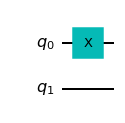

QPE computed electronic ground state energy (Hartree): -1.793437861067976
 
Running the VQE using the Heuristic ansatz, the Two-Local circuit with SLSQP
Elapsed time: 0:00:02.249209 

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.857275010328
  - computed part:      -1.857275010328
~ Nuclear repulsion energy (Hartree): 0.719968994449
> Total ground state energy (Hartree): -1.137306015879
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  1.3889487]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  1.3889487]
    - computed part:      [0.0  0.0  1.3889487]
  > Dipole moment (a.u.): [0.0  0.0  0.0]  Total: 0.0
                 (debye): [0.0  0.0  0.0]  Total: 0.0
 


In [35]:
H2_fermionic_hamiltonian, H2_particle_number, H2_qubit_op, H2_qubit_converter, H2_ground_state = \
                  solve_ground_state(h2_molecule, mapper ="Parity",
                   two_qubit_reduction=True, z2symmetry_reduction=None, 
                   name_solver = 'Heuristic ansatz, the Two-Local circuit with SLSQP',solver = vqe_tl_solver)

The following cells may take a long time to run

In [36]:
qnspsa_loss = []
ansatz = tl_circuit
fidelity = QNSPSA.get_fidelity(ansatz, quantum_instance, expectation=PauliExpectation())
qnspsa = QNSPSA(fidelity, maxiter=200, learning_rate=0.01, perturbation=0.7, callback=qnspsaclb)

Set up VQE using a heuristic ansatz and the QN-SPSA optimizer:

In [37]:
vqe_tl_QNSPSA_solver = VQE(ansatz=tl_circuit, optimizer=qnspsa,
                     quantum_instance=quantum_instance)

In [38]:
import matplotlib.pyplot as plt

Call solve_ground_state() with the heuristic ansatz and the QN-SPSA optimizer.

Number of alpha electrons: 1
Number of beta electrons: 1
Number of spin orbitals: 4
Fermionic Hamiltonian operator
Fermionic Operator
register length=4, number terms=36
  -1.2563390730032498 * ( +_0 -_0 )
+ -0.47189600728114245 * ( +_1 -_1 )
+ -1.2563390730032498 * ( +_2 -_2 )
+ -0.47189600728114245 * ( +_3 -_3 )
+ -0.33785507740175813 * ( +_0 +_0 -_0 -_0 )
+ -0.09046559989211564 * ( +_0 +_1 -_1 -_0 )
+ -0.09046559989211556 * ( +_0 +_0 -_1 -_1 )
+ -0.33229086512764816 * ( +_0 +_1 -_0 -_1 )
+ -0.33785507740175813 * ( +_0 +_2 -_0 -_2 )
+ -0.09046559989211564 * ( +_0 +_3 -_1 -_2 )
+ -0.09046559989211556 * ( +_0 +_2 -_1 -_3 )
+ -0.33229086512764816 * ( +_0 +_3 -_0 -_3 )
+ -0.33229086512764827 * ( +_1 +_0 -_1 -_0 )
+ -0.09046559989211574 * ( +_1 +_1 -_0 -_0 )
+ -0.09046559989211565 * ( +_1 +_0 -_0 -_1 )
+ -0.34928686136600906 * ( +_1 +_1 -_1 -_1 )
+ -0.33229086512764827 * ( +_1 +_2 -_1 -_2 )
+ -0.09046559989211574 * ( +_1 +_3 -_0 -_2 )
+ -0.09046559989211565 * ( +_1 +_2 -_0 -_3 )
+ -0.34928

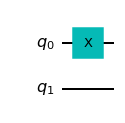

QPE computed electronic ground state energy (Hartree): -1.793437861067976
 
Running the VQE using the Two-Local circuit and the QN-SPSA optimizer
Elapsed time: 0:02:10.361601 

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.80501716615
  - computed part:      -1.80501716615
~ Nuclear repulsion energy (Hartree): 0.719968994449
> Total ground state energy (Hartree): -1.085048171701
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.047 S^2: 0.050 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  1.3889487]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  1.39257305]
    - computed part:      [0.0  0.0  1.39257305]
  > Dipole moment (a.u.): [0.0  0.0  -0.00362435]  Total: 0.00362435
                 (debye): [0.0  0.0  -0.00921218]  Total: 0.00921218
 


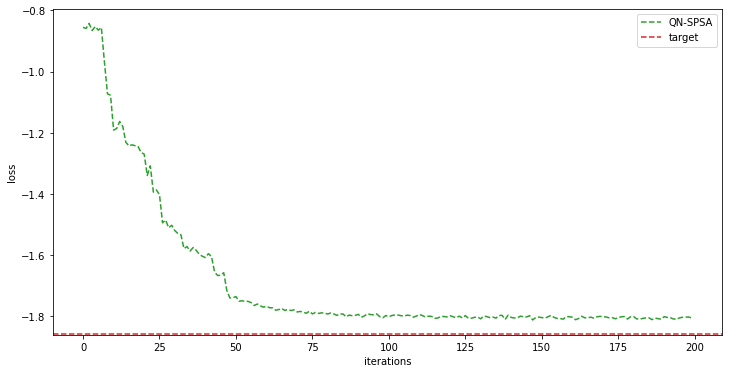

In [39]:
H2_fermionic_hamiltonian, H2_particle_number, H2_qubit_op, H2_qubit_converter, H2_ground_state = \
                  solve_ground_state(h2_molecule, mapper ="Parity",
                  two_qubit_reduction=True, z2symmetry_reduction=None, loss=qnspsa_loss, label='QN-SPSA', target=-1.857274810366,
                  name_solver='Two-Local circuit and the QN-SPSA optimizer', solver=vqe_tl_QNSPSA_solver)